<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/examples/experiments/solubility2F_JCIM_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet

! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet

In [3]:
! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet

In [4]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


Try compare whether transfer learning or pretrain with multiobjective, which is better

In [115]:
import pandas as pd
print('try compare with paper JCIM 2023 solubility to bioavailability transfer learning')
data_path = '/content/drive/MyDrive/ADMET/solubility2F_JCIM_2023.xlsx'
F_train = pd.read_excel(data_path, sheet_name=1)
print(F_train.head())
print('bioavailability len train:', len(F_train))
F_test = pd.read_excel(data_path, sheet_name=2)
print('bioavailability len test:', len(F_test))
sol_train = pd.read_excel(data_path, sheet_name=7)
sol_valid = pd.read_excel(data_path, sheet_name=8)
len(sol_train), len(sol_valid)

try compare with paper JCIM 2023 solubility to bioavailability transfer learning
               Name                              smile value  label_cutoff_50%
0      sulfadiazine      Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1    90                 1
1       clofarabine  Nc1nc(Cl)nc2c1ncn2C1OC(CO)C(O)C1F    50                 1
2  sulfamethoxazole    Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1    99                 1
3        tolazoline                c1ccc(CC2=NCCN2)cc1    90                 1
4          cotinine               CN1C(=O)CCC1c1cccnc1    97                 1
bioavailability len train: 1157
bioavailability len test: 290


(7880, 978)

In [88]:
F_train

,Name,smile,value,label_cutoff_50%
0,sulfadiazine,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,90,1
1,clofarabine,Nc1nc(Cl)nc2c1ncn2C1OC(CO)C(O)C1F,50,1
2,sulfamethoxazole,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,99,1
3,tolazoline,c1ccc(CC2=NCCN2)cc1,90,1
4,cotinine,CN1C(=O)CCC1c1cccnc1,97,1
...,...,...,...,...
1152,clonidine,Clc1cccc(Cl)c1NC1=NCCN1,95,1
1153,guanfacine,N=C(N)N=C(O)Cc1c(Cl)cccc1Cl,81,1
1154,diloxanide,CN(C(=O)C(Cl)Cl)c1ccc(O)cc1,90,1
1155,clodronate,O=P([O-])([O-])C(Cl)(Cl)P(=O)(O)O,1,0


In [23]:
# trains = pd.DataFrame()
# valids = pd.DataFrame()

trains = sol_train[['SMILES', 'logS']].reset_index(drop=True)
valids = sol_valid[['SMILES', 'logS']].reset_index(drop=True)
trains = trains.rename(columns={'SMILES': 'Drug'})
valids = valids.rename(columns={'SMILES': 'Drug'})

F_train = F_train.rename(columns={'smile':'Drug', 'label_cutoff_50%':'F'})
F_test = F_test.rename(columns={'smile':'Drug', 'label_cutoff_50%':'F'})
train = F_train[['Drug', 'F']].reset_index(drop=True)
valid = F_test[['Drug', 'F']].reset_index(drop=True)
trains = trains.merge(train, how='outer')
valids = valids.merge(valid, how='outer')

In [33]:
trains = sol_train[['SMILES', 'logS']].reset_index(drop=True)
valids = sol_valid[['SMILES', 'logS']].reset_index(drop=True)
trains = trains.rename(columns={'SMILES': 'Drug'})
valids = valids.rename(columns={'SMILES': 'Drug'})


In [28]:
trains = trains.rename(columns={'SMILES': 'Drug'})
valids = valids.rename(columns={'SMILES': 'Drug'})

Mixed data. logS is regression while F is binary classification

In [25]:
from dgllife.model import load_pretrained
from dgl.nn.pytorch.glob import AvgPooling
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from functools import partial
import torch
from dgllife.utils import smiles_to_bigraph, PretrainAtomFeaturizer, PretrainBondFeaturizer

MASK = -100

class GIN_dataset(Dataset):
    def __init__(self, df, names, mask=MASK):
        df = df.fillna(mask)
        self.names = names
        self.df = df
        self.len = len(df)
        self.props = self.df[names]
        self.node_featurizer = PretrainAtomFeaturizer()
        self.edge_featurizer = PretrainBondFeaturizer()
        self.fc = partial(smiles_to_bigraph, add_self_loop=True)
    def __len__(self): return self.len
    def __getitem__(self, idx):
        v_d = self.df.iloc[idx]['Drug']
        v_d = self.fc(smiles=v_d, node_featurizer = self.node_featurizer,
                      edge_featurizer = self.edge_featurizer)
        label = torch.tensor(self.props.iloc[idx], dtype=torch.float32)
        return v_d, label

import dgl
def get_GIN_dataloader(datasets, loader_params):
    def dgl_collate_func(data):
        x, labels = map(list, zip(*data))
        bg = dgl.batch(x)
        labels = torch.stack(labels, dim=0)
        bg.set_n_initializer(dgl.init.zero_initializer)
        bg.set_e_initializer(dgl.init.zero_initializer)
        return bg, labels
    loader_params['collate_fn'] = dgl_collate_func
    return DataLoader(datasets, **loader_params)

,SMILES,logS,F
0,CCCCC(COC(=O)N)(COC(=O)NC(C)C)C,-3.633502,NaN
1,O=P(c1ccccc1)(c1ccccc1)Cc1ccccc1,-4.397670,NaN
2,CCC(=O)N1C2CCC1CN(C2)C(c1ccccc1)c1ccccc1,-4.760920,NaN
3,Clc1cc(Cl)c(c(c1)c1cc(Cl)c(cc1Cl)Cl)Cl,-8.600000,NaN
4,CN1CCC(CC1)N(c1ccccc1)Cc1ccccc1,-4.086451,NaN
...,...,...,...
9032,Clc1cccc(Cl)c1NC1=NCCN1,NaN,1.0
9033,N=C(N)N=C(O)Cc1c(Cl)cccc1Cl,NaN,1.0
9034,CN(C(=O)C(Cl)Cl)c1ccc(O)cc1,NaN,1.0
9035,O=P([O-])([O-])C(Cl)(Cl)P(=O)(O)O,NaN,0.0


In [29]:
from dgllife.model import load_pretrained
from dgl.nn.pytorch.glob import AvgPooling
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from functools import partial
import torch
from dgllife.utils import smiles_to_bigraph, PretrainAtomFeaturizer, PretrainBondFeaturizer

MASK = -100

class GIN_dataset(Dataset):
    def __init__(self, df, names, mask=MASK):
        df = df.fillna(mask)
        self.names = names
        self.df = df
        self.len = len(df)
        self.props = self.df[names]
        self.node_featurizer = PretrainAtomFeaturizer()
        self.edge_featurizer = PretrainBondFeaturizer()
        self.fc = partial(smiles_to_bigraph, add_self_loop=True)
    def __len__(self): return self.len
    def __getitem__(self, idx):
        v_d = self.df.iloc[idx]['Drug']
        v_d = self.fc(smiles=v_d, node_featurizer = self.node_featurizer,
                      edge_featurizer = self.edge_featurizer)
        label = torch.tensor(self.props.iloc[idx], dtype=torch.float32)
        return v_d, label



DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:

import dgl
def get_GIN_dataloader(datasets, loader_params):
    def dgl_collate_func(data):
        x, labels = map(list, zip(*data))
        bg = dgl.batch(x)
        labels = torch.stack(labels, dim=0)
        bg.set_n_initializer(dgl.init.zero_initializer)
        bg.set_e_initializer(dgl.init.zero_initializer)
        return bg, labels
    loader_params['collate_fn'] = dgl_collate_func
    return DataLoader(datasets, **loader_params)


In [120]:
from dgllife.utils import EarlyStopping, Meter
from tqdm import tqdm

def train_epoch(epoch, model, loader, loss_func, device,
                optimizer=None, names=None, MASK=-100):
    if optimizer==None: model.eval(); train_type='Valid'
    else: model.train(); train_type='Train'
    losses = 0
    y_probs = {}
    y_label = {}
    # for idx, batch in tqdm(enumerate(loader), total=len(loader), desc=f'Epoch {epoch}'):
    for idx, batch in enumerate(loader):
        bg, labels = batch
        bg, labels = bg.to(device), labels.to(device)
        mask = labels == MASK
        pred = model(bg)
        loss = loss_func(pred[~mask], labels[~mask])
        # del mask
        losses += loss.item()
        if optimizer != None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if names != None:
            for j, name in enumerate(names):
                probs = F.sigmoid(pred[:, j][~mask[:, j]])
                label = labels[:, j][~mask[:, j]]
                probs = probs.cpu().detach().numpy().tolist()
                label = label.cpu().detach().numpy().tolist()
                if idx ==0: y_probs[name], y_label[name] = probs, label
                else:
                    y_probs[name] += probs
                    y_label[name] += label

        # if idx % 10 == 0: print(losses)
    total_loss = losses / len(loader.dataset)
    print(f'Epoch:{epoch}, [{train_type}] Loss: {total_loss:.3f}')
    if names == None or train_type == 'train': return total_loss
    else: return total_loss, y_probs, y_label


In [123]:
from dgllife.utils import EarlyStopping, Meter
from tqdm import tqdm

def train_epoch_reg(epoch, model, loader, loss_func, device,
                optimizer=None, names=None, MASK=-100):
    if optimizer==None: model.eval(); train_type='Valid'
    else: model.train(); train_type='Train'
    losses = 0
    y_probs = {}
    y_label = {}
    # for idx, batch in tqdm(enumerate(loader), total=len(loader), desc=f'Epoch {epoch}'):
    for idx, batch in enumerate(loader):
        bg, labels = batch
        bg, labels = bg.to(device), labels.to(device)
        mask = labels == MASK
        pred = model(bg)
        loss = loss_func(pred[~mask], labels[~mask])
        # del mask
        losses += loss.item()
        if optimizer != None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if names != None:
            for j, name in enumerate(names):
                probs = pred[:, j][~mask[:, j]]
                label = labels[:, j][~mask[:, j]]
                probs = probs.cpu().detach().numpy().tolist()
                label = label.cpu().detach().numpy().tolist()
                if idx ==0: y_probs[name], y_label[name] = probs, label
                else:
                    y_probs[name] += probs
                    y_label[name] += label

        # if idx % 10 == 0: print(losses)
    total_loss = losses / len(loader.dataset)
    print(f'Epoch:{epoch}, [{train_type}] Loss: {total_loss:.3f}')
    if names == None or train_type == 'train': return total_loss
    else: return total_loss, y_probs, y_label


In [119]:
from dgllife.utils import EarlyStopping, Meter
from tqdm import tqdm

def train_epoch_mix(epoch, model, loader, IS_Rs, device,
                optimizer=None, names=None, MASK=-100):
    if optimizer==None: model.eval(); train_type='Valid'
    else: model.train(); train_type='Train'

    losses = 0
    y_probs = {}
    y_label = {}
    # for idx, batch in tqdm(enumerate(loader), total=len(loader), desc=f'Epoch {epoch}'):
    for idx, batch in enumerate(loader):
        bg, labels = batch
        bg, labels = bg.to(device), labels.to(device)
        mask = labels == MASK
        pred = model(bg)

        if names != None:
            for j, name in enumerate(names):
                IS_R = IS_Rs[j]
                if IS_R:
                    loss_func = nn.MSELoss(reduction='sum') # if regression
                    probs = pred[:, j][~mask[:, j]]
                else:
                    loss_func = nn.BCEWithLogitsLoss(reduction='sum') # if classification
                    probs = F.sigmoid(pred[:, j][~mask[:, j]])
                label = labels[:, j][~mask[:, j]]
                if j == 0: loss = loss_func(pred[:, j][~mask[:, j]], label)
                else: loss += loss_func(pred[:, j][~mask[:, j]], label)

                if train_type != 'Train':
                    probs = probs.cpu().detach().numpy().tolist()
                    label = label.cpu().detach().numpy().tolist()
                    if idx ==0: y_probs[name], y_label[name] = probs, label
                    else:
                        y_probs[name] += probs
                        y_label[name] += label

        # del mask
        losses += loss.item()
        if optimizer != None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # if idx % 10 == 0: print(losses)
    total_loss = losses / len(loader.dataset)
    print(f'Epoch:{epoch}, [{train_type}] Loss: {total_loss:.3f}')
    if names == None or train_type == 'train': return total_loss
    else: return total_loss, y_probs, y_label


In [124]:
import torch.nn.functional as F
from scripts.eval_utils import *
from scripts.preprocess_mols import *
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

device = 'cuda'
import sklearn.metrics as metrics

import numpy as np

def reg_evaluate(label_clean, preds_clean):
    mae = metrics.mean_absolute_error(label_clean, preds_clean)
    mse = metrics.mean_squared_error(label_clean, preds_clean)
    rmse = np.sqrt(mse) #mse**(0.5)
    r2 = metrics.r2_score(label_clean, preds_clean)

    print('MAE,   MSE,   RMSE,   R2')
    print("& %5.3f" % (mae), " &%5.3f" % (mse), " &%5.3f" % (rmse),
      " &%5.3f" % (r2))

    eval_result_r2 =   f'R2:     {r2:.3f}'
    eval_result_mae =  f'MAE:   {mae:.3f}'
    eval_result_rmse = f'RMSE: {rmse:.3f}'

    return eval_result_r2, eval_result_mae, eval_result_rmse

from mycolorpy import colorlist as mcp
import matplotlib.pyplot as plt

def eval_dict(y_probs:dict, y_label:dict, names:list, IS_R=False, draw_fig=False):
    if isinstance(IS_R, list): task_list = IS_R
    else: task_list = [IS_R] * len(names)
    for i, name in enumerate(names):
        IS_R = task_list[i]
        print('*'*15, name, '*'*15)
        probs = y_probs[name]
        label = y_label[name]
        assert len(probs) == len(label)
        if IS_R == False:
            preds = get_preds(0.5, probs)
            evaluate(label, preds, probs)

        else:
            r2, mae, rmse = reg_evaluate(label, probs)
            if draw_fig:
                color = mcp.gen_color_normalized(cmap='viridis',
                                                data_arr=label)
                plt.scatter(label, probs, cmap='viridis', marker='.',
                            s=10, alpha=0.5, edgecolors='none', c=color)
                plt.xlabel(f'True {name}')
                plt.ylabel(f'Predicted {name}')
                plt.title(f'{name} prediction on test set')

                x0, xmax = plt.xlim()
                y0, ymax = plt.ylim()
                data_width = xmax - x0
                data_height = ymax - y0
                # print(x0, xmax, y0, ymax, data_width, data_height)
                plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8/0.95, r2)
                plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8,  mae)
                plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8*0.95, rmse)

                plt.show()
                plt.cla()
                plt.clf()
                plt.close()
        print()



def eval_AP(model, IS_R, test_loader, names, device=device):
    # print('Evaluate on test sets')
    # model = model.cpu()
    model.eval()
    total_loss = 0
    y_probs = {}
    y_label = {}
    if IS_R: print('using MSELoss')
    else: print('using BCELOSSwithdigits')
    if IS_R: loss_fn = nn.MSELoss(reduction='sum') # if regression
    else: loss_fn = nn.BCEWithLogitsLoss(reduction='sum') # if classification
    for i, batch_data in tqdm(enumerate(test_loader), total=len(test_loader)):
        bg, labels = batch_data
        bg, labels = bg.to(device), labels.to(device)
        pred = model(bg)
        mask = labels == MASK
        loss = loss_fn(pred[~mask], labels[~mask])
        total_loss += loss.item()
        for j, name in enumerate(names):
            if IS_R: probs = pred[:, j][~mask[:, j]]
            else: probs = F.sigmoid(pred[:, j][~mask[:, j]])
            label = labels[:, j][~mask[:, j]]
            probs = probs.cpu().detach().numpy().tolist()
            label = label.cpu().detach().numpy().tolist()
            if i ==0: y_probs[name], y_label[name] = probs, label
            else:
                y_probs[name] += probs
                y_label[name] += label

    total_loss /= len(test_loader.dataset)
    print(f'total_loss: {total_loss:.3f}')

    eval_dict(y_probs, y_label, names, IS_R, True)

    return y_probs, y_label


In [125]:

class GIN_MOD(nn.Module):
    """
    Reference: https://github.com/kexinhuang12345/DeepPurpose/blob/master/DeepPurpose/encoders.py#L392
    """
	## adapted from https://github.com/awslabs/dgl-lifesci/blob/2fbf5fd6aca92675b709b6f1c3bc3c6ad5434e96/examples/property_prediction/moleculenet/utils.py#L76
    def __init__(self, **config):
        super(GIN_MOD, self).__init__()
        self.gnn = load_pretrained('gin_supervised_contextpred')
        self.readout = AvgPooling()
        self.transform = nn.Linear(300, config['GIN_out_dim'])
        self.dropout = nn.Dropout(config['dropout'])
        self.hidden_dims = config['hid_dims']
        self.out_dim = config['out_dim']
        layer_size = len(self.hidden_dims)
        neurons = [config['GIN_out_dim'], *self.hidden_dims]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        self.final = nn.Linear(self.hidden_dims[-1], self.out_dim)

    def forward(self, bg):
        # bg = bg.to(device)
        node_feats = [
            bg.ndata.pop('atomic_number'),
            bg.ndata.pop('chirality_type')
        ]
        edge_feats = [
            bg.edata.pop('bond_type'),
            bg.edata.pop('bond_direction_type')
        ]

        node_feats = self.gnn(bg, node_feats, edge_feats)
        x = self.readout(bg, node_feats)
        x = self.transform(x)
        for layer in self.hidden: x = F.leaky_relu(layer(x))
        x = self.final(x)
        return self.dropout(x)


In [126]:


class PRED:
    def __init__(self, **config):
        cuda = torch.cuda.is_available()
        if cuda: self.device = 'cuda'
        else:    self.device = 'cpu'
        self.prop_names = config['prop_names']
        self.model = GIN_MOD(**config).to(self.device)
        self.config = config
        self.IS_R = config['IS_R']
        if self.IS_R: loss_fn = nn.MSELoss(reduction='sum') # if regression
        elif self.IS_R==False:
            loss_fn = nn.BCEWithLogitsLoss(reduction='sum') # if classification
        self.loss_fn = loss_fn
        self.optimizer = torch.optim.AdamW(self.model.parameters(),
                    lr=config['lr'], weight_decay=config['wd'])
        self.stopper = EarlyStopping(mode='lower', patience=config['patience'])
        self.min_loss = 10000
        self.best_epoch = 0

    def load_model(self, path):
        con = self.config.copy()
        # con['dropout'] = 0
        self.model = GIN_MOD(**con).to(self.device)
        print('load pretrained model from ', path)
        self.model.load_state_dict(torch.load(path, map_location=self.device))

    def eval(self, loader, path=None):
        # self.load_model(path)
        if path != None: self.load_model(path)
        eval_AP(self.model, self.IS_R, loader, self.prop_names)

    def train(self, data_loader, val_loader, test_loader=None, train_epoch=train_epoch):
        if self.IS_R: train_epoch = train_epoch_reg
        if self.best_epoch != 0: self.load_model(self.config['model_path'])

        for epoch in range(500):
            score = train_epoch(epoch, self.model, data_loader, self.loss_fn,
                                self.device, self.optimizer)
            val_score, probs, labels = \
                    train_epoch(epoch, self.model, val_loader, self.loss_fn,
                                self.device, names=self.prop_names)

            early_stop = self.stopper.step(val_score, self.model)
            if val_score < self.min_loss:
                print(f'prev min loss {self.min_loss:.3f}, '
                      f'now loss {val_score:.3f} |',
                      f'save model at epoch: {epoch}')
                self.min_loss = val_score
                torch.save(self.model.state_dict(), self.config['model_path'])
                self.best_epoch = epoch
                eval_dict(probs, labels, self.prop_names, IS_R=self.IS_R)
                # self.eval(val_data_loader, 'ckpt_.pt')
            if early_stop: print('early stop'); break

        print(f"best epoch: {self.best_epoch}, min loss: {self.min_loss:.4f}")
        print()
        if test_loader != None: self.eval(test_loader, self.config['model_path'])


###Single objective

#### logS

In [127]:
trains = sol_train[['SMILES', 'logS']].reset_index(drop=True)
valids = sol_valid[['SMILES', 'logS']].reset_index(drop=True)
trains = trains.rename(columns={'SMILES': 'Drug'})
valids = valids.rename(columns={'SMILES': 'Drug'})

In [128]:
trains.head() # regression task

,Drug,logS
0,CCCCC(COC(=O)N)(COC(=O)NC(C)C)C,-3.633502
1,O=P(c1ccccc1)(c1ccccc1)Cc1ccccc1,-4.397670
2,CCC(=O)N1C2CCC1CN(C2)C(c1ccccc1)c1ccccc1,-4.760920
3,Clc1cc(Cl)c(c(c1)c1cc(Cl)c(cc1Cl)Cl)Cl,-8.600000
4,CN1CCC(CC1)N(c1ccccc1)Cc1ccccc1,-4.086451


In [129]:
names = ['logS']
batch_size = 128
loader_params ={'batch_size': batch_size, 'shuffle': True}
train_loader = get_GIN_dataloader(GIN_dataset(trains, names), loader_params)
loader_params ={'batch_size': batch_size, 'shuffle': False}
valid_loader = get_GIN_dataloader(GIN_dataset(valids, names), loader_params)

In [130]:
IS_R = True
config = {'GIN_out_dim': 256,
            'hid_dims': [512],
            'out_dim': len(names),
            'prop_names': names,
            'dropout': 0.1,
            'IS_R': IS_R,
            'lr': 1e-4,
            'wd':1e-5,
            'patience': 10,
            'model_path': f'GIN_SO_DR_0.1/ckpt_{names[0]}.pt'}

In [131]:
models = PRED(**config)
models.train(train_loader, valid_loader)

Pretrained model loaded
Epoch:0, [Train] Loss: 11.897
Epoch:0, [Valid] Loss: 7.658
prev min loss 10000.000, now loss 7.658 | save model at epoch: 0
*************** logS ***************
MAE,   MSE,   RMSE,   R2
& 2.189  &7.658  &2.767  &-0.654

Epoch:1, [Train] Loss: 5.734
Epoch:1, [Valid] Loss: 2.795
prev min loss 7.658, now loss 2.795 | save model at epoch: 1
*************** logS ***************
MAE,   MSE,   RMSE,   R2
& 1.273  &2.795  &1.672  &0.396

Epoch:2, [Train] Loss: 4.104
Epoch:2, [Valid] Loss: 2.348
prev min loss 2.795, now loss 2.348 | save model at epoch: 2
*************** logS ***************
MAE,   MSE,   RMSE,   R2
& 1.148  &2.348  &1.532  &0.493

Epoch:3, [Train] Loss: 3.856
Epoch:3, [Valid] Loss: 2.185
prev min loss 2.348, now loss 2.185 | save model at epoch: 3
*************** logS ***************
MAE,   MSE,   RMSE,   R2
& 1.097  &2.185  &1.478  &0.528

Epoch:4, [Train] Loss: 3.792
Epoch:4, [Valid] Loss: 2.067
prev min loss 2.185, now loss 2.067 | save model at epoc

Pretrained model loaded
load pretrained model from  GIN_SO_DR_0.1/ckpt_logS.pt
using MSELoss


100%|██████████| 8/8 [00:02<00:00,  3.38it/s]


total_loss: 1.403
*************** logS ***************
MAE,   MSE,   RMSE,   R2
& 0.847  &1.403  &1.185  &0.697


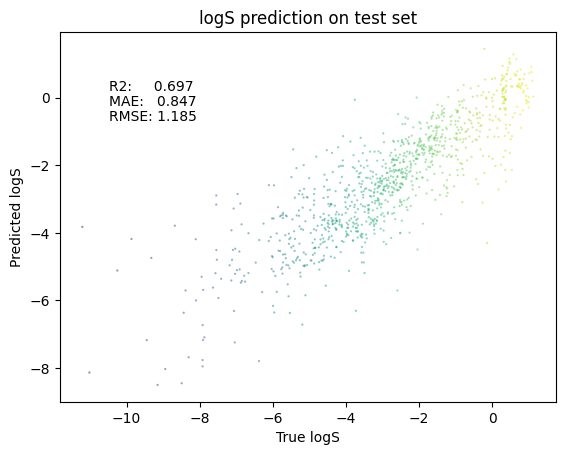

In [132]:
models.eval(valid_loader, config['model_path'])

In [ ]:
names = ['Lipophilicity_AstraZeneca', 'Solubility_AqSolDB', 'HydrationFreeEnergy_FreeSolv']
IS_R = True
trains, valids, tests = collect_data(names, IS_R=IS_R)
batch_size = 128
loader_params ={'batch_size': batch_size, 'shuffle': True}

train_loader = get_GIN_dataloader(GIN_dataset(trains, names), loader_params)
valid_loader = get_GIN_dataloader(GIN_dataset(valids, names), loader_params)
p = {'batch_size': batch_size, 'shuffle': False}
test_loader = get_GIN_dataloader(GIN_dataset(tests, names), p)

In [135]:
config = {'GIN_out_dim': 256,
          'hid_dims': [64],
          'out_dim': len(names),
          'prop_names': names,
          'dropout': 0.1,
          'IS_R': IS_R,
          'lr': 5e-4,
          'wd':1e-5,
          'patience': 5,
          'model_path': f'ckpt_GIN_MO_regression.pt'}

models = PRED(**config)

Pretrained model loaded


Epoch:0, [Train] Loss: 7.026
Epoch:0, [Valid] Loss: 3.042
prev min loss 10000.000, now loss 3.042 | save model at epoch: 0
*************** Lipophilicity_AstraZeneca ***************
MAE,   MSE,   RMSE,   R2
& 0.953  &1.278  &1.131  &0.111

*************** Solubility_AqSolDB ***************
MAE,   MSE,   RMSE,   R2
& 1.215  &2.601  &1.613  &0.510

*************** HydrationFreeEnergy_FreeSolv ***************
MAE,   MSE,   RMSE,   R2
& 3.540  &21.107  &4.594  &-0.790

Epoch:1, [Train] Loss: 4.125
Epoch:1, [Valid] Loss: 2.405
prev min loss 3.042, now loss 2.405 | save model at epoch: 1
*************** Lipophilicity_AstraZeneca ***************
MAE,   MSE,   RMSE,   R2
& 0.909  &1.157  &1.076  &0.195

*************** Solubility_AqSolDB ***************
MAE,   MSE,   RMSE,   R2
& 1.183  &2.482  &1.575  &0.532

*************** HydrationFreeEnergy_FreeSolv ***************
MAE,   MSE,   RMSE,   R2
& 2.197  &9.089  &3.015  &0.229

Epoch:2, [Train] Loss: 3.507
Epoch:2, [Valid] Loss: 2.239
prev min l

100%|██████████| 23/23 [00:07<00:00,  3.03it/s]


total_loss: 1.443
*************** Lipophilicity_AstraZeneca ***************
MAE,   MSE,   RMSE,   R2
& 0.644  &0.637  &0.798  &0.569


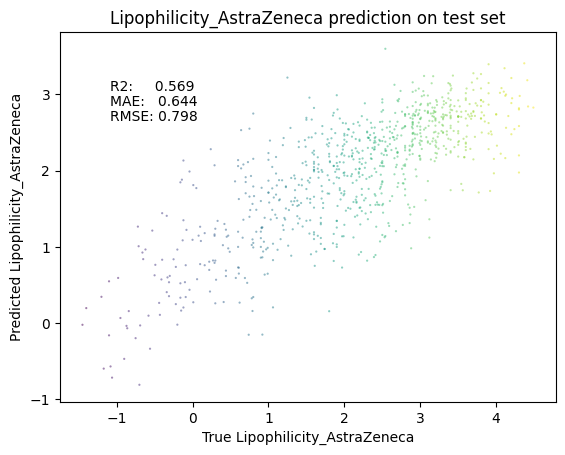


*************** Solubility_AqSolDB ***************
MAE,   MSE,   RMSE,   R2
& 0.949  &1.689  &1.300  &0.689


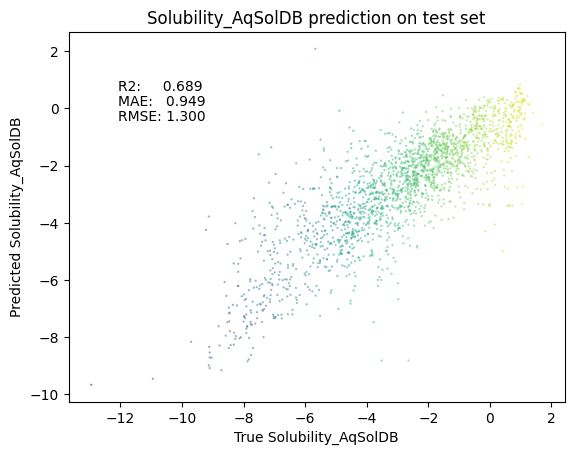


*************** HydrationFreeEnergy_FreeSolv ***************
MAE,   MSE,   RMSE,   R2
& 1.168  &2.554  &1.598  &0.844


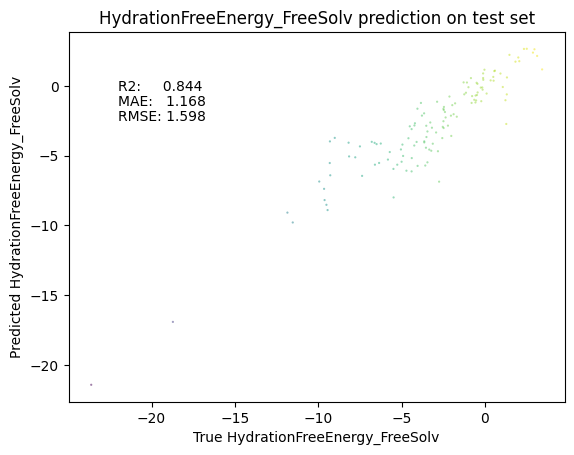

In [136]:
models.train(train_loader, valid_loader, test_loader)

Pretrained model loaded
load pretrained model from  ckpt_GIN_MO_regression.pt
using MSELoss


100%|██████████| 23/23 [00:07<00:00,  3.21it/s]


total_loss: 1.443
*************** Lipophilicity_AstraZeneca ***************
MAE,   MSE,   RMSE,   R2
& 0.644  &0.637  &0.798  &0.569


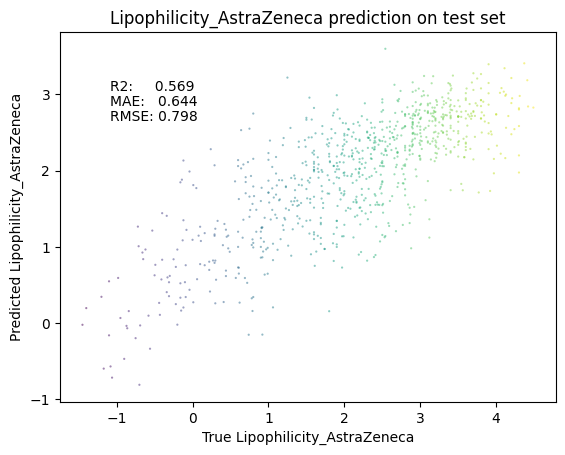


*************** Solubility_AqSolDB ***************
MAE,   MSE,   RMSE,   R2
& 0.949  &1.689  &1.300  &0.689


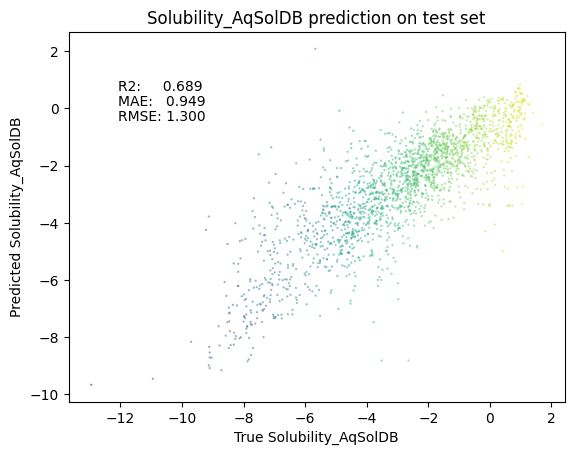


*************** HydrationFreeEnergy_FreeSolv ***************
MAE,   MSE,   RMSE,   R2
& 1.168  &2.554  &1.598  &0.844


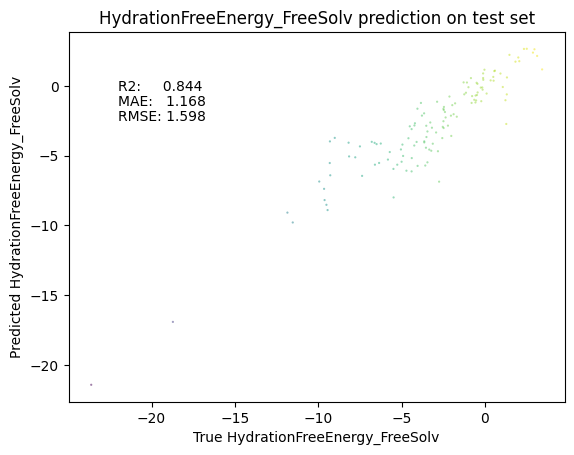

In [137]:
# label, probs = eval_AP(models.model, IS_R, test_loader, names, device=device)
models.eval(test_loader, config['model_path'])

In [98]:
F_train = F_train.rename(columns={'smile':'Drug', 'label_cutoff_50%':'F'})
F_test = F_test.rename(columns={'smile':'Drug', 'label_cutoff_50%':'F'})
trains = F_train[['Drug', 'F']].reset_index(drop=True)
valids = F_test[['Drug', 'F']].reset_index(drop=True)
trains

,Drug,F
0,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,1
1,Nc1nc(Cl)nc2c1ncn2C1OC(CO)C(O)C1F,1
2,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,1
3,c1ccc(CC2=NCCN2)cc1,1
4,CN1C(=O)CCC1c1cccnc1,1
...,...,...
1152,Clc1cccc(Cl)c1NC1=NCCN1,1
1153,N=C(N)N=C(O)Cc1c(Cl)cccc1Cl,1
1154,CN(C(=O)C(Cl)Cl)c1ccc(O)cc1,1
1155,O=P([O-])([O-])C(Cl)(Cl)P(=O)(O)O,0


In [100]:
names = ['F']
IS_R = False
batch_size = 128
loader_params ={'batch_size': batch_size, 'shuffle': True}

train_loader = get_GIN_dataloader(GIN_dataset(trains, names), loader_params)
valid_loader = get_GIN_dataloader(GIN_dataset(valids, names), loader_params)
# p = {'batch_size': batch_size, 'shuffle': False}
# test_loader = get_GIN_dataloader(GIN_dataset(tests, names), p)

In [101]:
IS_R = False
config = {'GIN_out_dim': 256,
            'hid_dims': [512],
            'out_dim': len(names),
            'prop_names': names,
            'dropout': 0.1,
            'IS_R': IS_R,
            'lr': 1e-4,
            'wd':1e-5,
            'patience': 10,
            'model_path': f'GIN_SO_DR_0.1/ckpt_{names[0]}.pt'}

In [ ]:
models = PRED(**config)
models.train(train_loader, valid_loader)

In [105]:
models.eval(valid_loader, config['model_path'])

Pretrained model loaded
load pretrained model from  GIN_SO_DR_0.1/ckpt_F.pt
using BCELOSSwithdigits


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]

total_loss: 0.571
*************** F ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.655  &  0.637  &          0.689  &     0.746  &0.529  &0.716 &0.751 &   0.281 &   0.808



GIN not working well, use AttentiveFP

In [64]:
trains

,Drug,Lipophilicity_AstraZeneca,Solubility_AqSolDB,HydrationFreeEnergy_FreeSolv
0,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54,NaN,NaN
1,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,-1.18,NaN,NaN
2,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,3.69,NaN,NaN
3,OC1(C#Cc2ccc(-c3ccccc3)cc2)CN2CCC1CC2,3.14,NaN,NaN
4,CS(=O)(=O)c1ccc(Oc2ccc(C#C[C@]3(O)CN4CCC3CC4)c...,1.51,NaN,NaN
...,...,...,...,...
9984,C#CCCC,NaN,NaN,0.01
9985,Cc1ccc(O)cc1,NaN,NaN,-6.13
9986,CCCCC/C=C/C=O,NaN,NaN,-3.43
9987,CCOP(=S)(OCC)Oc1cc(C)nc(C(C)C)n1,NaN,NaN,-6.48


In [65]:

import pandas as pd

import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import EarlyStopping, Meter
from dgllife.utils import AttentiveFPAtomFeaturizer
from dgllife.utils import AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset

def collate_molgraphs(data):
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)

    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
        # masks = (labels == MASK).long()
    return smiles, bg, labels, masks


atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
n_feats_num = atom_featurizer.feat_size('hv')
e_feats_num = bond_featurizer.feat_size('he')

In [106]:
import time
named_tuple = time.localtime() # get struct_time
time_string = time.strftime("%m_%d_%Y_%H:%M:%S", named_tuple)

params = {'node_featurizer': atom_featurizer,
          'edge_featurizer': bond_featurizer,
          'smiles_column': 'Drug',
        #   'cache_file_path': time_string+'.bin',
          'task_names': names, 'load': True, 'n_jobs': len(names)}

train_datasets = MoleculeCSVDataset(trains, cache_file_path=f'train_{time_string}.bin', **params)
valid_datasets = MoleculeCSVDataset(valids,cache_file_path=f'valid_{time_string}.bin', **params)
# test_datasets = MoleculeCSVDataset(tests, cache_file_path=f'test_{time_string}.bin', **params)

batch_size = 64
loader_params ={'batch_size': batch_size,
                'shuffle': True,
                'collate_fn': collate_molgraphs}

train_loader = DataLoader(train_datasets, **loader_params)
valid_loader = DataLoader(valid_datasets, **loader_params)
test_loader  = DataLoader(test_datasets,  **loader_params)

Processing dgl graphs from scratch...
Processing molecule 1000/1157
Processing dgl graphs from scratch...


In [107]:
cuda = torch.cuda.is_available()
if cuda: device = 'cuda'
else: device = 'cpu'
n_layers = 3
dropout = 0.5

model = model_zoo.AttentiveFPPredictor(
            node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
            num_layers=n_layers, num_timesteps=1, graph_feat_size=300,
            n_tasks=len(names), dropout=dropout).to(device)

In [108]:

def train_epoch(epoch, model, data_loader, loss_func, optimizer):
    model.train()
    losses = 0
    train_meter = Meter()
    for batch_id, batch_data in tqdm(enumerate(data_loader),
                                     total=len(data_loader),
                                     desc=f'Epoch {epoch}'):
        smiles, bg, labels, masks = batch_data
        bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
        n_feats = bg.ndata.pop('hv').to(device)
        e_feats = bg.edata.pop('he').to(device)

        pred = model(bg, n_feats, e_feats)
        mask = masks < 1
        loss = loss_func(pred[~mask], labels[~mask])
        del mask
        # loss = (loss_func(pred, labels)*(masks!=0).float()).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_meter.update(pred, labels, masks)
        del pred
        del labels
        del masks
        losses += loss.item()
        # losses.append(loss.item())

    total_r2 = np.mean(train_meter.compute_metric('r2'))
    total_loss = losses / len(data_loader.dataset)
    # if epoch % 10 == 0 and epoch != 0:
    print(f'[Train] R2: {total_r2:.3f}, Loss: {total_loss:.3f}')

    return total_r2, total_loss

def eval_epoch(model, data_loader, loss_func):
    model.eval()
    val_losses = 0
    eval_meter = Meter()
    with torch.no_grad():
        for batch_data in data_loader:
            smiles, bg, labels, masks = batch_data
            bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
            n_feats = bg.ndata.pop('hv').to(device)
            e_feats = bg.edata.pop('he').to(device)
            val_pred = model(bg, n_feats, e_feats)
            mask = masks < 1
            val_loss = loss_func(val_pred[~mask], labels[~mask])
            # val_loss = (loss_func(val_pred, labels)*(masks!=0).float()).mean()
            # val_losses.append(val_loss.item())
            val_losses += val_loss.item()
            eval_meter.update(val_pred, labels, masks)
            del val_pred
            del labels
            del masks
            del n_feats
            del e_feats
        total_score = np.mean(eval_meter.compute_metric('r2'))
        total_loss = val_losses / len(data_loader.dataset)
        print(f'[Valid] R2: {total_score:.3f}, Loss: {total_loss:.3f}')
    return total_score, total_loss


In [109]:

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
stopper = EarlyStopping(mode='lower', patience=30)
n_epochs = 500
best_epoch = 0
min_loss = 100000
if IS_R: loss_fn = nn.MSELoss(reduction='sum') # if regression
else: loss_fn = nn.BCEWithLogitsLoss(reduction='sum') # if classification

print(IS_R)

False


In [110]:

if best_epoch != 0:
    model.load_state_dict(torch.load('ckpt.pt', map_location=device))

for epoch in range(best_epoch, best_epoch + n_epochs):
    score = train_epoch(epoch, model, train_loader, loss_fn, optimizer)
    val_score = eval_epoch(model, valid_loader, loss_fn)
    early_stop = stopper.step(val_score[1], model)
    if val_score[1] < min_loss and epoch > 3:
        print(f'prev min loss {min_loss:.3f}, now better loss {val_score[1]:.3f}')
        min_loss = val_score[1]
        torch.save(model.state_dict(), 'ckpt.pt')
        print(f'save model at epoch: {epoch}')
        best_epoch = epoch

    if early_stop: print('early stop'); break


Epoch 0: 100%|██████████| 19/19 [00:00<00:00, 30.65it/s]


[Train] R2: 0.009, Loss: 0.693
[Valid] R2: 0.135, Loss: 0.635


Epoch 1: 100%|██████████| 19/19 [00:00<00:00, 34.39it/s]


[Train] R2: 0.019, Loss: 0.684
[Valid] R2: 0.155, Loss: 0.638
EarlyStopping counter: 1 out of 30


Epoch 2: 100%|██████████| 19/19 [00:00<00:00, 34.53it/s]


[Train] R2: 0.027, Loss: 0.680
[Valid] R2: 0.157, Loss: 0.629


Epoch 3: 100%|██████████| 19/19 [00:00<00:00, 36.12it/s]


[Train] R2: 0.031, Loss: 0.675
[Valid] R2: 0.160, Loss: 0.619


Epoch 4: 100%|██████████| 19/19 [00:00<00:00, 35.86it/s]


[Train] R2: 0.053, Loss: 0.661
[Valid] R2: 0.169, Loss: 0.610
prev min loss 100000.000, now better loss 0.610
save model at epoch: 4


Epoch 5: 100%|██████████| 19/19 [00:00<00:00, 35.40it/s]


[Train] R2: 0.034, Loss: 0.673
[Valid] R2: 0.173, Loss: 0.616
EarlyStopping counter: 1 out of 30


Epoch 6: 100%|██████████| 19/19 [00:00<00:00, 36.10it/s]


[Train] R2: 0.045, Loss: 0.668
[Valid] R2: 0.176, Loss: 0.636
EarlyStopping counter: 2 out of 30


Epoch 7: 100%|██████████| 19/19 [00:00<00:00, 37.37it/s]


[Train] R2: 0.041, Loss: 0.671
[Valid] R2: 0.174, Loss: 0.616
EarlyStopping counter: 3 out of 30


Epoch 8: 100%|██████████| 19/19 [00:00<00:00, 35.74it/s]


[Train] R2: 0.059, Loss: 0.659
[Valid] R2: 0.184, Loss: 0.629
EarlyStopping counter: 4 out of 30


Epoch 9: 100%|██████████| 19/19 [00:00<00:00, 35.49it/s]


[Train] R2: 0.053, Loss: 0.664
[Valid] R2: 0.182, Loss: 0.604
prev min loss 0.610, now better loss 0.604
save model at epoch: 9


Epoch 10: 100%|██████████| 19/19 [00:00<00:00, 37.08it/s]


[Train] R2: 0.084, Loss: 0.647
[Valid] R2: 0.197, Loss: 0.618
EarlyStopping counter: 1 out of 30


Epoch 11: 100%|██████████| 19/19 [00:00<00:00, 37.20it/s]


[Train] R2: 0.086, Loss: 0.645
[Valid] R2: 0.198, Loss: 0.588
prev min loss 0.604, now better loss 0.588
save model at epoch: 11


Epoch 12: 100%|██████████| 19/19 [00:00<00:00, 35.81it/s]


[Train] R2: 0.080, Loss: 0.649
[Valid] R2: 0.194, Loss: 0.600
EarlyStopping counter: 1 out of 30


Epoch 13: 100%|██████████| 19/19 [00:00<00:00, 36.69it/s]


[Train] R2: 0.089, Loss: 0.643
[Valid] R2: 0.196, Loss: 0.592
EarlyStopping counter: 2 out of 30


Epoch 14: 100%|██████████| 19/19 [00:00<00:00, 37.83it/s]


[Train] R2: 0.111, Loss: 0.630
[Valid] R2: 0.204, Loss: 0.579
prev min loss 0.588, now better loss 0.579
save model at epoch: 14


Epoch 15: 100%|██████████| 19/19 [00:00<00:00, 36.27it/s]


[Train] R2: 0.108, Loss: 0.631
[Valid] R2: 0.218, Loss: 0.579
prev min loss 0.579, now better loss 0.579
save model at epoch: 15


Epoch 16: 100%|██████████| 19/19 [00:00<00:00, 35.89it/s]


[Train] R2: 0.117, Loss: 0.626
[Valid] R2: 0.211, Loss: 0.574
prev min loss 0.579, now better loss 0.574
save model at epoch: 16


Epoch 17: 100%|██████████| 19/19 [00:00<00:00, 36.94it/s]


[Train] R2: 0.115, Loss: 0.626
[Valid] R2: 0.211, Loss: 0.567
prev min loss 0.574, now better loss 0.567
save model at epoch: 17


Epoch 18: 100%|██████████| 19/19 [00:00<00:00, 35.97it/s]


[Train] R2: 0.120, Loss: 0.619
[Valid] R2: 0.219, Loss: 0.571
EarlyStopping counter: 1 out of 30


Epoch 19: 100%|██████████| 19/19 [00:00<00:00, 39.58it/s]


[Train] R2: 0.124, Loss: 0.619
[Valid] R2: 0.224, Loss: 0.598
EarlyStopping counter: 2 out of 30


Epoch 20: 100%|██████████| 19/19 [00:00<00:00, 39.72it/s]


[Train] R2: 0.128, Loss: 0.613
[Valid] R2: 0.218, Loss: 0.565
prev min loss 0.567, now better loss 0.565
save model at epoch: 20


Epoch 21: 100%|██████████| 19/19 [00:00<00:00, 37.05it/s]


[Train] R2: 0.145, Loss: 0.603
[Valid] R2: 0.223, Loss: 0.554
prev min loss 0.565, now better loss 0.554
save model at epoch: 21


Epoch 22: 100%|██████████| 19/19 [00:00<00:00, 40.40it/s]


[Train] R2: 0.141, Loss: 0.602
[Valid] R2: 0.216, Loss: 0.565
EarlyStopping counter: 1 out of 30


Epoch 23: 100%|██████████| 19/19 [00:00<00:00, 39.43it/s]


[Train] R2: 0.153, Loss: 0.598
[Valid] R2: 0.233, Loss: 0.579
EarlyStopping counter: 2 out of 30


Epoch 24: 100%|██████████| 19/19 [00:00<00:00, 30.91it/s]


[Train] R2: 0.146, Loss: 0.596
[Valid] R2: 0.226, Loss: 0.551
prev min loss 0.554, now better loss 0.551
save model at epoch: 24


Epoch 25: 100%|██████████| 19/19 [00:00<00:00, 39.11it/s]


[Train] R2: 0.152, Loss: 0.602
[Valid] R2: 0.219, Loss: 0.568
EarlyStopping counter: 1 out of 30


Epoch 26: 100%|██████████| 19/19 [00:00<00:00, 38.00it/s]


[Train] R2: 0.143, Loss: 0.597
[Valid] R2: 0.220, Loss: 0.560
EarlyStopping counter: 2 out of 30


Epoch 27: 100%|██████████| 19/19 [00:00<00:00, 40.86it/s]


[Train] R2: 0.177, Loss: 0.574
[Valid] R2: 0.201, Loss: 0.572
EarlyStopping counter: 3 out of 30


Epoch 28: 100%|██████████| 19/19 [00:00<00:00, 39.68it/s]


[Train] R2: 0.176, Loss: 0.573
[Valid] R2: 0.202, Loss: 0.560
EarlyStopping counter: 4 out of 30


Epoch 29: 100%|██████████| 19/19 [00:00<00:00, 38.10it/s]


[Train] R2: 0.196, Loss: 0.562
[Valid] R2: 0.215, Loss: 0.557
EarlyStopping counter: 5 out of 30


Epoch 30: 100%|██████████| 19/19 [00:00<00:00, 38.64it/s]


[Train] R2: 0.167, Loss: 0.578
[Valid] R2: 0.183, Loss: 0.560
EarlyStopping counter: 6 out of 30


Epoch 31: 100%|██████████| 19/19 [00:00<00:00, 39.65it/s]


[Train] R2: 0.174, Loss: 0.562
[Valid] R2: 0.195, Loss: 0.557
EarlyStopping counter: 7 out of 30


Epoch 32: 100%|██████████| 19/19 [00:00<00:00, 39.32it/s]


[Train] R2: 0.180, Loss: 0.565
[Valid] R2: 0.177, Loss: 0.589
EarlyStopping counter: 8 out of 30


Epoch 33: 100%|██████████| 19/19 [00:00<00:00, 38.71it/s]


[Train] R2: 0.190, Loss: 0.554
[Valid] R2: 0.186, Loss: 0.558
EarlyStopping counter: 9 out of 30


Epoch 34: 100%|██████████| 19/19 [00:00<00:00, 40.99it/s]


[Train] R2: 0.194, Loss: 0.548
[Valid] R2: 0.182, Loss: 0.585
EarlyStopping counter: 10 out of 30


Epoch 35: 100%|██████████| 19/19 [00:00<00:00, 38.50it/s]


[Train] R2: 0.194, Loss: 0.550
[Valid] R2: 0.182, Loss: 0.569
EarlyStopping counter: 11 out of 30


Epoch 36: 100%|██████████| 19/19 [00:00<00:00, 38.96it/s]


[Train] R2: 0.203, Loss: 0.549
[Valid] R2: 0.198, Loss: 0.549
prev min loss 0.551, now better loss 0.549
save model at epoch: 36


Epoch 37: 100%|██████████| 19/19 [00:00<00:00, 39.29it/s]


[Train] R2: 0.178, Loss: 0.546
[Valid] R2: 0.202, Loss: 0.549
prev min loss 0.549, now better loss 0.549
save model at epoch: 37


Epoch 38: 100%|██████████| 19/19 [00:00<00:00, 38.03it/s]


[Train] R2: 0.201, Loss: 0.545
[Valid] R2: 0.197, Loss: 0.571
EarlyStopping counter: 1 out of 30


Epoch 39: 100%|██████████| 19/19 [00:00<00:00, 38.81it/s]


[Train] R2: 0.185, Loss: 0.550
[Valid] R2: 0.130, Loss: 0.598
EarlyStopping counter: 2 out of 30


Epoch 40: 100%|██████████| 19/19 [00:00<00:00, 38.32it/s]


[Train] R2: 0.208, Loss: 0.543
[Valid] R2: 0.209, Loss: 0.563
EarlyStopping counter: 3 out of 30


Epoch 41: 100%|██████████| 19/19 [00:00<00:00, 40.18it/s]


[Train] R2: 0.208, Loss: 0.538
[Valid] R2: 0.181, Loss: 0.565
EarlyStopping counter: 4 out of 30


Epoch 42: 100%|██████████| 19/19 [00:00<00:00, 37.63it/s]


[Train] R2: 0.208, Loss: 0.539
[Valid] R2: 0.219, Loss: 0.541
prev min loss 0.549, now better loss 0.541
save model at epoch: 42


Epoch 43: 100%|██████████| 19/19 [00:00<00:00, 39.82it/s]


[Train] R2: 0.198, Loss: 0.552
[Valid] R2: 0.230, Loss: 0.533
prev min loss 0.541, now better loss 0.533
save model at epoch: 43


Epoch 44: 100%|██████████| 19/19 [00:00<00:00, 39.65it/s]


[Train] R2: 0.196, Loss: 0.536
[Valid] R2: 0.191, Loss: 0.547
EarlyStopping counter: 1 out of 30


Epoch 45: 100%|██████████| 19/19 [00:00<00:00, 42.21it/s]


[Train] R2: 0.201, Loss: 0.534
[Valid] R2: 0.186, Loss: 0.555
EarlyStopping counter: 2 out of 30


Epoch 46: 100%|██████████| 19/19 [00:00<00:00, 38.18it/s]


[Train] R2: 0.203, Loss: 0.531
[Valid] R2: 0.179, Loss: 0.562
EarlyStopping counter: 3 out of 30


Epoch 47: 100%|██████████| 19/19 [00:00<00:00, 40.95it/s]


[Train] R2: 0.199, Loss: 0.527
[Valid] R2: 0.161, Loss: 0.571
EarlyStopping counter: 4 out of 30


Epoch 48: 100%|██████████| 19/19 [00:00<00:00, 40.87it/s]


[Train] R2: 0.212, Loss: 0.513
[Valid] R2: 0.137, Loss: 0.603
EarlyStopping counter: 5 out of 30


Epoch 49: 100%|██████████| 19/19 [00:00<00:00, 39.05it/s]


[Train] R2: 0.199, Loss: 0.533
[Valid] R2: 0.197, Loss: 0.538
EarlyStopping counter: 6 out of 30


Epoch 50: 100%|██████████| 19/19 [00:00<00:00, 39.84it/s]


[Train] R2: 0.214, Loss: 0.522
[Valid] R2: 0.202, Loss: 0.580
EarlyStopping counter: 7 out of 30


Epoch 51: 100%|██████████| 19/19 [00:00<00:00, 39.65it/s]


[Train] R2: 0.209, Loss: 0.530
[Valid] R2: 0.158, Loss: 0.583
EarlyStopping counter: 8 out of 30


Epoch 52: 100%|██████████| 19/19 [00:00<00:00, 40.17it/s]


[Train] R2: 0.192, Loss: 0.534
[Valid] R2: 0.161, Loss: 0.556
EarlyStopping counter: 9 out of 30


Epoch 53: 100%|██████████| 19/19 [00:00<00:00, 41.75it/s]


[Train] R2: 0.202, Loss: 0.520
[Valid] R2: 0.157, Loss: 0.575
EarlyStopping counter: 10 out of 30


Epoch 54: 100%|██████████| 19/19 [00:00<00:00, 39.84it/s]


[Train] R2: 0.213, Loss: 0.516
[Valid] R2: 0.175, Loss: 0.565
EarlyStopping counter: 11 out of 30


Epoch 55: 100%|██████████| 19/19 [00:00<00:00, 40.03it/s]


[Train] R2: 0.222, Loss: 0.508
[Valid] R2: 0.177, Loss: 0.557
EarlyStopping counter: 12 out of 30


Epoch 56: 100%|██████████| 19/19 [00:00<00:00, 39.95it/s]


[Train] R2: 0.215, Loss: 0.523
[Valid] R2: 0.162, Loss: 0.584
EarlyStopping counter: 13 out of 30


Epoch 57: 100%|██████████| 19/19 [00:00<00:00, 40.62it/s]


[Train] R2: 0.203, Loss: 0.523
[Valid] R2: 0.188, Loss: 0.551
EarlyStopping counter: 14 out of 30


Epoch 58: 100%|██████████| 19/19 [00:00<00:00, 42.36it/s]


[Train] R2: 0.220, Loss: 0.509
[Valid] R2: 0.172, Loss: 0.558
EarlyStopping counter: 15 out of 30


Epoch 59: 100%|██████████| 19/19 [00:00<00:00, 38.85it/s]


[Train] R2: 0.226, Loss: 0.505
[Valid] R2: 0.169, Loss: 0.567
EarlyStopping counter: 16 out of 30


Epoch 60: 100%|██████████| 19/19 [00:00<00:00, 42.17it/s]


[Train] R2: 0.223, Loss: 0.497
[Valid] R2: 0.168, Loss: 0.597
EarlyStopping counter: 17 out of 30


Epoch 61: 100%|██████████| 19/19 [00:00<00:00, 38.91it/s]


[Train] R2: 0.234, Loss: 0.496
[Valid] R2: 0.172, Loss: 0.601
EarlyStopping counter: 18 out of 30


Epoch 62: 100%|██████████| 19/19 [00:00<00:00, 41.15it/s]


[Train] R2: 0.234, Loss: 0.506
[Valid] R2: 0.156, Loss: 0.599
EarlyStopping counter: 19 out of 30


Epoch 63: 100%|██████████| 19/19 [00:00<00:00, 39.49it/s]


[Train] R2: 0.233, Loss: 0.499
[Valid] R2: 0.174, Loss: 0.588
EarlyStopping counter: 20 out of 30


Epoch 64: 100%|██████████| 19/19 [00:00<00:00, 40.99it/s]


[Train] R2: 0.237, Loss: 0.507
[Valid] R2: 0.190, Loss: 0.559
EarlyStopping counter: 21 out of 30


Epoch 65: 100%|██████████| 19/19 [00:00<00:00, 39.79it/s]


[Train] R2: 0.259, Loss: 0.487
[Valid] R2: 0.196, Loss: 0.551
EarlyStopping counter: 22 out of 30


Epoch 66: 100%|██████████| 19/19 [00:00<00:00, 40.59it/s]


[Train] R2: 0.240, Loss: 0.494
[Valid] R2: 0.193, Loss: 0.574
EarlyStopping counter: 23 out of 30


Epoch 67: 100%|██████████| 19/19 [00:00<00:00, 38.34it/s]


[Train] R2: 0.253, Loss: 0.489
[Valid] R2: 0.180, Loss: 0.585
EarlyStopping counter: 24 out of 30


Epoch 68: 100%|██████████| 19/19 [00:00<00:00, 27.83it/s]


[Train] R2: 0.268, Loss: 0.480
[Valid] R2: 0.191, Loss: 0.567
EarlyStopping counter: 25 out of 30


Epoch 69: 100%|██████████| 19/19 [00:00<00:00, 29.17it/s]


[Train] R2: 0.272, Loss: 0.476
[Valid] R2: 0.199, Loss: 0.582
EarlyStopping counter: 26 out of 30


Epoch 70: 100%|██████████| 19/19 [00:00<00:00, 39.94it/s]


[Train] R2: 0.273, Loss: 0.487
[Valid] R2: 0.194, Loss: 0.604
EarlyStopping counter: 27 out of 30


Epoch 71: 100%|██████████| 19/19 [00:00<00:00, 41.13it/s]


[Train] R2: 0.264, Loss: 0.487
[Valid] R2: 0.177, Loss: 0.585
EarlyStopping counter: 28 out of 30


Epoch 72: 100%|██████████| 19/19 [00:00<00:00, 41.47it/s]


[Train] R2: 0.280, Loss: 0.474
[Valid] R2: 0.191, Loss: 0.584
EarlyStopping counter: 29 out of 30


Epoch 73: 100%|██████████| 19/19 [00:00<00:00, 41.57it/s]

[Train] R2: 0.283, Loss: 0.467
[Valid] R2: 0.173, Loss: 0.596
EarlyStopping counter: 30 out of 30
early stop


In [112]:
model = model_zoo.AttentiveFPPredictor(
            node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
            num_layers=n_layers, num_timesteps=1, graph_feat_size=300,
            n_tasks=len(names)).to(device)

model.load_state_dict(torch.load('ckpt.pt', map_location=device))

<All keys matched successfully>

In [113]:
test_loader = valid_loader
print('Evaluate on test sets')
model = model.cpu()
model.eval()
total_loss = 0
test_meter = Meter()
if IS_R: print('using MSELoss')
else: print('using BCELOSSwithdigits')

for i, batch_data in tqdm(enumerate(test_loader), total=len(test_loader)):
    smiles, bg, labels, masks = batch_data
    # bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
    # n_feats = bg.ndata.pop('hv').to(device)
    # e_feats = bg.edata.pop('he').to(device)
    n_feats = bg.ndata.pop('hv')
    e_feats = bg.edata.pop('he')

    pred = model(bg, n_feats, e_feats)
    # loss = (loss_fn(pred, labels)*(masks!=0).float()).mean()
    mask = masks < 1
    loss = loss_fn(pred[~mask], labels[~mask])
    test_meter.update(pred, labels, masks)
    # print(loss)
    total_loss += loss.item()
    if i == 0:
        preds_ = pred.cpu()
        labels_ = labels.cpu()
        masks_ = mask.cpu()
    else:
        preds_ = torch.cat([preds_, pred.cpu()], dim=0)
        labels_ = torch.cat([labels_, labels.cpu()], dim=0)
        masks_ = torch.cat([masks_, mask.cpu()], dim=0)
# masks_ = masks_ < 1
# preds_, labels_ = preds_.detach().numpy(), labels_.detach().numpy()
total_loss /= len(tests)
print(f'total_loss: {total_loss:.3f}')



Evaluate on test sets
using BCELOSSwithdigits


100%|██████████| 5/5 [00:00<00:00, 16.70it/s]

total_loss: 0.053


In [114]:
from mycolorpy import colorlist as mcp
import matplotlib.pyplot as plt

if IS_R: # regression task
    r2 = test_meter.compute_metric('r2')
    r2_mean, r2_std = np.mean(r2), np.std(r2)
    # r2_avg = test_meter.compute_metric('r2', reduction='mean')
    mae = test_meter.compute_metric('mae')
    mae_mean, mae_std = np.mean(mae), np.std(mae)
    # mae_avg = test_meter.compute_metric('mae', reduction='mean')
    rmse = test_meter.compute_metric('rmse')
    rmse_mean, rmse_std = np.mean(rmse), np.std(rmse)
    # # rmse_avg = test_meter.compute_metric('rmse', reduction='mean')
    print('\nOVERALL\n')
    print(f' R2: \t{r2_mean:.3f} +/- {r2_std:.3f} \n',
        f'MAE: \t{mae_mean:.3f} +/- {mae_std:.3f} \n',
        f'RMSE: \t{rmse_mean:.3f} +/- {rmse_std:.3f}')

    print('\nSEPERATELY\n')
    for i, name in enumerate(names):

        try: name = name.split('_')[0]
        except: pass
        print('*'*15, name, '*'*15)
        fig = plt.figure()
        r2, mae, rmse = reg_evaluate(
                labels_[:, i][~masks_[:, i]].detach().numpy(),
                 preds_[:, i][~masks_[:, i]].detach().numpy())
        color = mcp.gen_color_normalized(cmap='viridis',
                data_arr=labels_[:, i][~masks_[:, i]].detach().numpy())

        plt.scatter(labels_[:, i][~masks_[:, i]].detach().numpy(),
                    preds_[:, i][~masks_[:, i]].detach().numpy(),
                    cmap='viridis', marker='.',
                    s=10, alpha=0.5, edgecolors='none', c=color)
        plt.xlabel(f'True {name}')
        plt.ylabel(f'Predicted {name}')
        plt.title(f'{name} prediction on test set using AttentiveFP')


        x0, xmax = plt.xlim()
        y0, ymax = plt.ylim()
        data_width = xmax - x0
        data_height = ymax - y0
        # print(x0, xmax, y0, ymax, data_width, data_height)
        plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8/0.95, r2)
        plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8,  mae)
        plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8*0.95, rmse)

        plt.show()
        plt.cla()
        plt.clf()
        plt.close()
if IS_R == False:
    for i, name in enumerate(names):
        try: name = name.split('_')[0]
        except: pass
        print('*'*15, name, '*'*15)
        probs = F.sigmoid(preds_[:, i][~masks_[:, i]])
        label = labels_[:, i][~masks_[:, i]]
        probs = probs.cpu().detach().numpy()
        label = label.cpu().detach().numpy()
        assert len(probs) == len(label)
        preds = get_preds(0.5, probs)
        evaluate(label, preds, probs)
        print()


*************** F ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.724  &  0.718  &          0.766  &     0.757  &0.678  &0.762 &0.801 &   0.434 &   0.849




OVERALL

 R2: 	0.860 +/- 0.000 
 MAE: 	0.597 +/- 0.000 
 RMSE: 	0.824 +/- 0.000

SEPERATELY

*************** logS ***************
MAE, MSE, RMSE, R2
& 0.597  &0.678  &0.824  &0.854


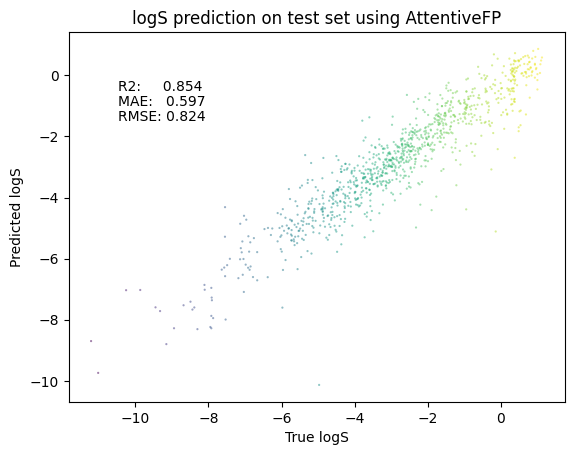

In [84]:
from mycolorpy import colorlist as mcp
import matplotlib.pyplot as plt

if IS_R: # regression task
    r2 = test_meter.compute_metric('r2')
    r2_mean, r2_std = np.mean(r2), np.std(r2)
    # r2_avg = test_meter.compute_metric('r2', reduction='mean')
    mae = test_meter.compute_metric('mae')
    mae_mean, mae_std = np.mean(mae), np.std(mae)
    # mae_avg = test_meter.compute_metric('mae', reduction='mean')
    rmse = test_meter.compute_metric('rmse')
    rmse_mean, rmse_std = np.mean(rmse), np.std(rmse)
    # # rmse_avg = test_meter.compute_metric('rmse', reduction='mean')
    print('\nOVERALL\n')
    print(f' R2: \t{r2_mean:.3f} +/- {r2_std:.3f} \n',
        f'MAE: \t{mae_mean:.3f} +/- {mae_std:.3f} \n',
        f'RMSE: \t{rmse_mean:.3f} +/- {rmse_std:.3f}')

    print('\nSEPERATELY\n')
    for i, name in enumerate(names):

        try: name = name.split('_')[0]
        except: pass
        print('*'*15, name, '*'*15)
        fig = plt.figure()
        r2, mae, rmse = reg_evaluate(
                labels_[:, i][~masks_[:, i]].detach().numpy(),
                 preds_[:, i][~masks_[:, i]].detach().numpy())
        color = mcp.gen_color_normalized(cmap='viridis',
                data_arr=labels_[:, i][~masks_[:, i]].detach().numpy())

        plt.scatter(labels_[:, i][~masks_[:, i]].detach().numpy(),
                    preds_[:, i][~masks_[:, i]].detach().numpy(),
                    cmap='viridis', marker='.',
                    s=10, alpha=0.5, edgecolors='none', c=color)
        plt.xlabel(f'True {name}')
        plt.ylabel(f'Predicted {name}')
        plt.title(f'{name} prediction on test set using AttentiveFP')


        x0, xmax = plt.xlim()
        y0, ymax = plt.ylim()
        data_width = xmax - x0
        data_height = ymax - y0
        # print(x0, xmax, y0, ymax, data_width, data_height)
        plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8/0.95, r2)
        plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8,  mae)
        plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8*0.95, rmse)

        plt.show()
        plt.cla()
        plt.clf()
        plt.close()
if IS_R == False:
    for i, name in enumerate(names):
        try: name = name.split('_')[0]
        except: pass
        print('*'*15, name, '*'*15)
        probs = F.sigmoid(preds_[:, i][~masks_[:, i]])
        label = labels_[:, i][~masks_[:, i]]
        probs = probs.cpu().detach().numpy()
        label = label.cpu().detach().numpy()
        assert len(probs) == len(label)
        preds = get_preds(0.5, probs)
        evaluate(label, preds, probs)
        print()


,Drug,Lipophilicity_AstraZeneca,Solubility_AqSolDB,HydrationFreeEnergy_FreeSolv
0,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54,NaN,NaN
1,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,-1.18,NaN,NaN
2,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,3.69,NaN,NaN
3,OC1(C#Cc2ccc(-c3ccccc3)cc2)CN2CCC1CC2,3.14,NaN,NaN
4,CS(=O)(=O)c1ccc(Oc2ccc(C#C[C@]3(O)CN4CCC3CC4)c...,1.51,NaN,NaN
...,...,...,...,...
9984,C#CCCC,NaN,NaN,0.01
9985,Cc1ccc(O)cc1,NaN,NaN,-6.13
9986,CCCCC/C=C/C=O,NaN,NaN,-3.43
9987,CCOP(=S)(OCC)Oc1cc(C)nc(C(C)C)n1,NaN,NaN,-6.48
